In [1]:
import string
import copy
import scipy
import Tkinter, tkFileDialog
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import os
import sys
import datetime
import matplotlib.units
import re
import glob
from numba import jit,int32
import time
sys.path.append(os.path.abspath("C:\Users\Scherer Lab E\Documents\GitHub\Python_Data_Analysis"))
import common_functions
%matplotlib inline

C:\Anaconda\lib\site-packages\skimage\viewer\utils\core.py:10: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  warn("Recommended matplotlib backend is `Agg` for full "


# Other Data Set

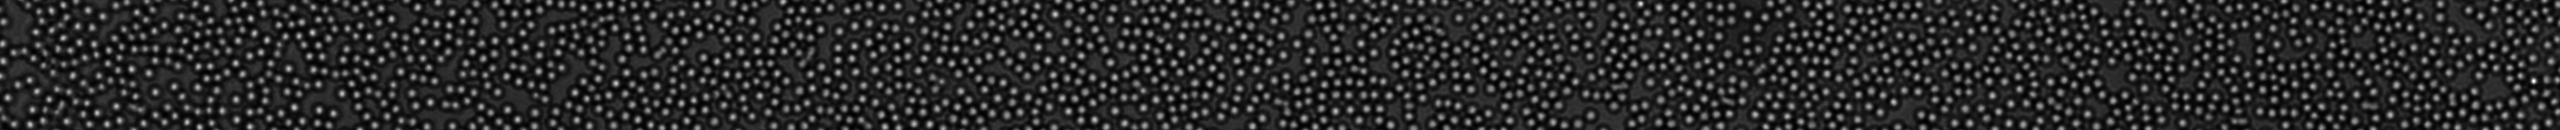

In [2]:
from IPython.display import Image
os.chdir("C:\Users\Scherer Lab E\Documents\IPython Notebooks\SPIFF Manuscript\Data")
Image(filename="06191317_example_image.png")

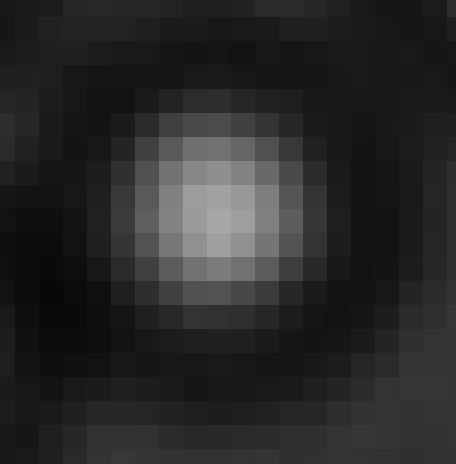

In [3]:
#os.chdir("C:\Users\Scherer Lab E\Documents\IPython Notebooks\Dynamical Phase Transition\Data\SPIFF")
Image(filename="06191317_particle_closeup.png")

### Import the Raghu Data for Mov_06191306 for different windows

Used windows with diameter 3, 5, 7, 9, 11, 13, 15, and 17 pixels.

In [7]:
os.chdir("C:\Users\Scherer Lab E\Downloads\TrackingGUI_and_associated_files_20July2014 My Version")

file_list = glob.glob('Mov_06191306-centroid*')
file_list = file_list[4:] + file_list[:4]
raghu_list = []
for traj_data in file_list:
    if len(traj_data) == 38:
        dia_size = int(traj_data[-5])
    elif len(traj_data) == 39:
        dia_size = int(traj_data[-6:-4])
    data = common_functions.import_matlab_gui(traj_data)
    df_raghu = common_functions.matlab_gui_to_data_frame(data)
    #df_mos = df_mos.rename(columns={'x': 'x pos', 'y': 'y pos', 'Trajectory': 'track id', 'Frame': 'frame'})
    raghu_list.append([df_raghu, dia_size])

Loading Mov_06191306-centroid_localized_w3.mat
Loading Mov_06191306-centroid_localized_w5.mat
Loading Mov_06191306-centroid_localized_w7.mat
Loading Mov_06191306-centroid_localized_w9.mat
Loading Mov_06191306-centroid_localized_w11.mat
Loading Mov_06191306-centroid_localized_w13.mat
Loading Mov_06191306-centroid_localized_w15.mat
Loading Mov_06191306-centroid_localized_w17.mat


### Re-Link Particles with Trackpy

In [10]:
import trackpy as tp

In [11]:
'''Link the image data for each window'''
tracked_data = []
for frame, window in raghu_list:
    tracked = tp.link_df(frame, 10, memory=1, pos_columns=['x pos', 'y pos'])
    tracked_data.append([tracked, window])

Frame 975: 3984 trajectories present


In [12]:
'''Checkpoint after linking'''
os.chdir("C:\Users\Scherer Lab E\Documents\IPython Notebooks\SPIFF Manuscript\Data")
import cPickle
pik = open('Ana_16042801_linked_positions.pkl', 'w')
cPickle.dump(tracked_data, pik)
pik.close()

In [9]:
import cPickle
pik = open('Ana_16042801_linked_positions.pkl', 'r')
tracked_data = cPickle.load(pik)
pik.close()

In [13]:
def disp_calc_en(grp, tau):
    if len(grp) < tau:
        return pd.Series([np.nan])
    #print grp[['x pos', 'y pos']],grp.shift(tau, axis=0)[['x pos', 'y pos']]
    disp = ((grp[['x pos', 'y pos']] - grp.shift(tau, axis=0)[['x pos', 'y pos']])**2).sum(skipna=False,axis=1)
    #if grp.name > 5000:
        #print grp.name
    return disp

def calc_en_msd(df, percent=0.3):
    en_msd = []
    pivot = pd.pivot_table(df, values=['x pos','y pos'], index='frame', columns='track id')
    for tau in range(int(max(df['frame'])*percent)):
        del_xy = (pivot - pivot.shift(tau+1, axis=0))**2
        en_msd.append((del_xy['x pos'] + del_xy['y pos']).stack().mean())
    return en_msd

Calculated the ensemble averaged MSD on the first 3rd of the data.

In [29]:
'''Calculate the ensemble MSD for each window'''
en_msd = []
for tracks, window in tracked_data:
    temp_track = tracks.drop('track id', axis=1)
    temp_track = temp_track.rename(columns={'x': 'x pos', 'y': 'y pos', 'particle': 'track id' })
    en_msd.append([calc_en_msd(temp_track),window])
    print 'done with window '+str(window)

done with window 3
done with window 5
done with window 7
done with window 9
done with window 11
done with window 13
done with window 15
done with window 17


In [15]:
'''Checkpoint after calculating ensemble MSD'''
import cPickle
pik = open('Ana_16042801_ensemble_msd.pkl', 'w')
cPickle.dump(en_msd, pik)
pik.close()

Average particles per frame = 4112.83384615


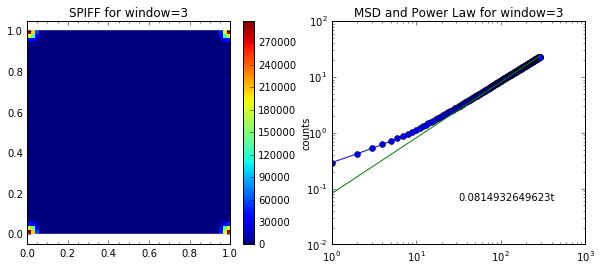

Average particles per frame = 4090.05435897


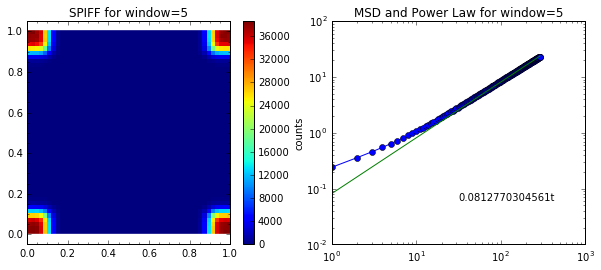

Average particles per frame = 4089.96205128


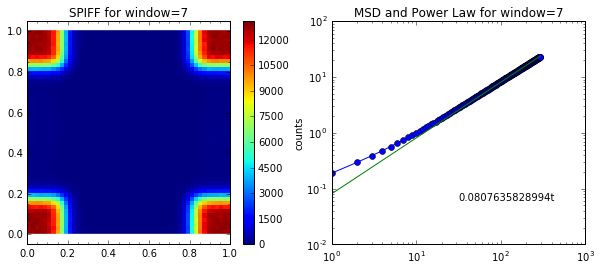

Average particles per frame = 4089.91487179


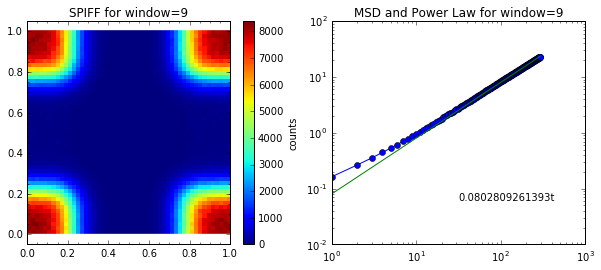

Average particles per frame = 4089.84820513


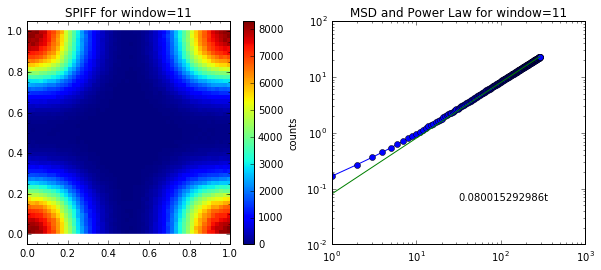

Average particles per frame = 4089.73948718


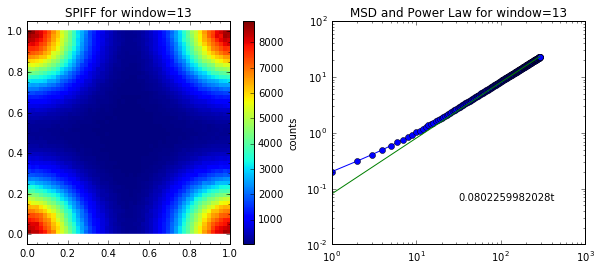

Average particles per frame = 4051.34461538


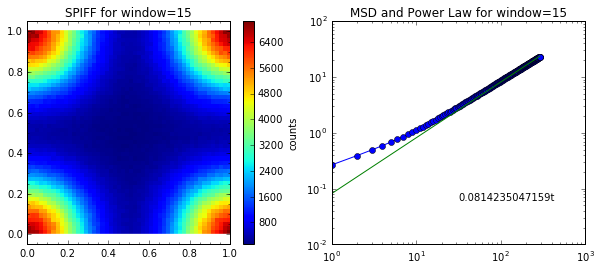

Average particles per frame = 4001.16205128


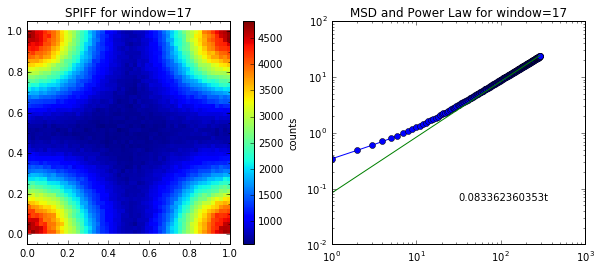

In [18]:
for num, entry in enumerate(tracked_data):
    df, window = entry
    plt.figure(figsize=[10,4])
    plt.subplot(121)
    plt.hist2d(df['x pos']%1, df['y pos']%1, bins=50)
    plt.axis('equal')
    cbar = plt.colorbar()
    cbar.set_label('counts')
    plt.minorticks_on()
    plt.title('SPIFF for window='+str(window))
    
    
    len_msd = len(en_msd[num][0])+1
    ax2 = plt.subplot(122)
    plt.plot(range(1,len_msd), en_msd[num][0], '-ob')
    pwr_law = lambda x, param: param*x
    fit_params = scipy.optimize.curve_fit(pwr_law, np.arange(1,len_msd), en_msd[num][0])
    plt.plot(np.arange(1,len_msd), pwr_law(np.arange(1,len_msd), fit_params[0][0]), 'g')
    plt.loglog()
    ax2.text(0.5, 0.2, str(fit_params[0][0])+'t', transform=ax2.transAxes)
    plt.title('MSD and Power Law for window='+str(window))
    
    print 'Average particles per frame = '+str(df.groupby('frame').apply(len).mean())
    
    plt.show()

## SPIFF Correction

Do the SPIFF correction on the Raghu Data

In [19]:
def spiff_correction(df, x_key='x', y_key='y'):
    df_copy = df.copy()
    spiff = df_copy[[x_key, y_key]] % 1
    spiff['spiff_x_corr'] = spiff[x_key].rank()/len(spiff)
    spiff['spiff_y_corr'] = spiff[y_key].rank()/len(spiff)
    df_copy[x_key] = np.floor(df_copy[x_key]) + spiff.spiff_x_corr
    df_copy[y_key] = np.floor(df_copy[y_key]) + spiff.spiff_y_corr
    return df_copy

In [20]:
corr_tracked_data = []
for tracks, window in tracked_data:
    tracks_temp = spiff_correction(tracks, x_key='x pos', y_key='y pos')
    corr_tracked_data.append([tracks_temp, window])

In [33]:
'''Calculate the ensemble MSD for each window (for only first third of tau)'''
corr_en_msd = []
for tracks, window in corr_tracked_data:
    temp_track = tracks.drop('track id', axis=1)
    temp_track = temp_track.rename(columns={'x': 'x pos', 'y': 'y pos', 'particle': 'track id' })
    corr_en_msd.append([calc_en_msd(temp_track),window])
    print 'done with window '+str(window)

done with window 3
done with window 5
done with window 7
done with window 9
done with window 11
done with window 13
done with window 15
done with window 17


### MSD of Corrected SPIFF

Average particles per frame = 4112.83384615


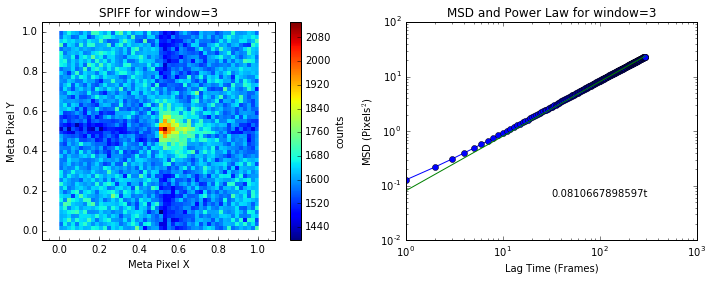

Average particles per frame = 4090.05435897


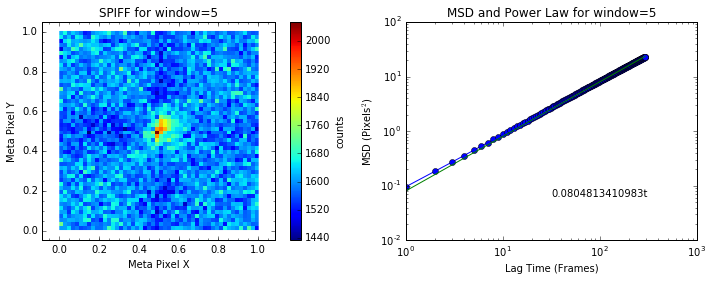

Average particles per frame = 4089.96205128


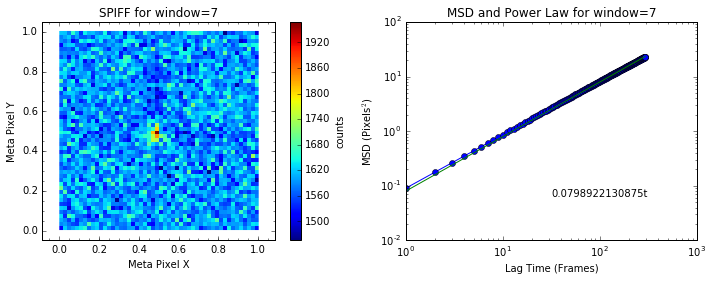

Average particles per frame = 4089.91487179


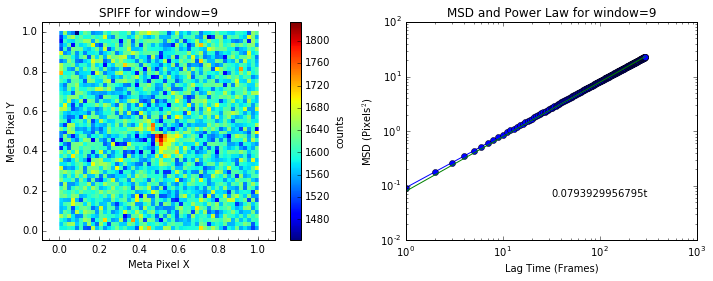

Average particles per frame = 4089.84820513


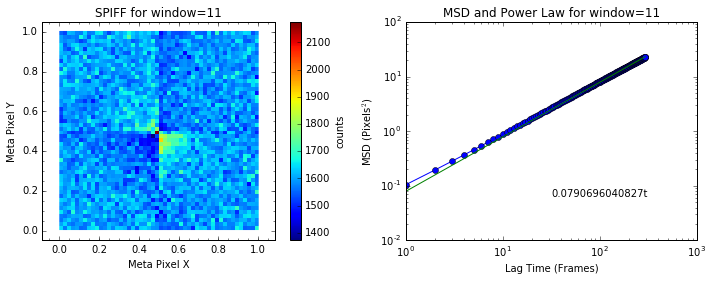

Average particles per frame = 4089.73948718


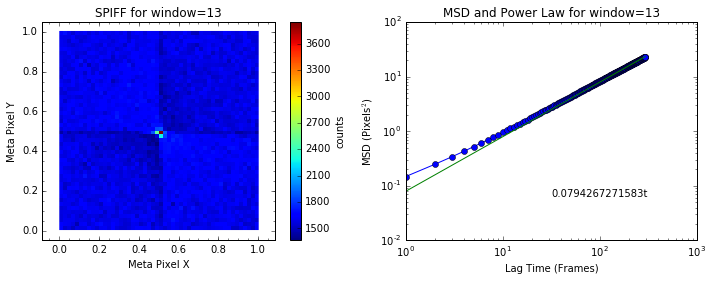

Average particles per frame = 4051.34461538


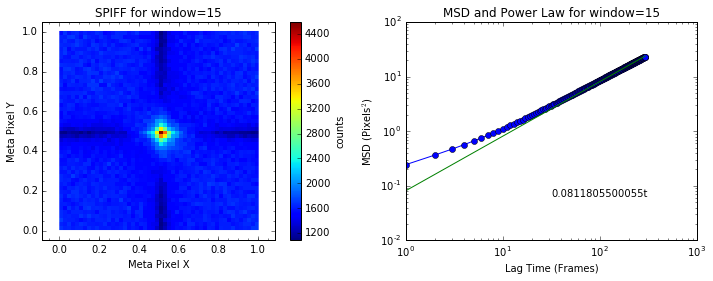

Average particles per frame = 4001.16205128


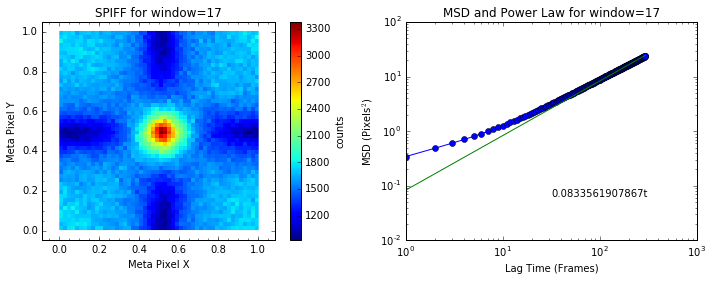

In [34]:
for num, entry in enumerate(corr_tracked_data):
    df, window = entry
    plt.figure(figsize=[10,4])
    plt.subplot(121)
    plt.hist2d(df['x pos']%1, df['y pos']%1, bins=50)
    plt.axis('equal')
    cbar = plt.colorbar()
    cbar.set_label('counts')
    plt.minorticks_on()
    plt.title('SPIFF for window='+str(window))
    plt.ylabel('Meta Pixel Y')
    plt.xlabel('Meta Pixel X')
    
    len_msd = len(corr_en_msd[num][0])+1
    ax2 = plt.subplot(122)
    plt.plot(range(1,len_msd), corr_en_msd[num][0], '-ob')
    pwr_law = lambda x, param: param*x
    fit_params = scipy.optimize.curve_fit(pwr_law, np.arange(1,len_msd)[-200:], corr_en_msd[num][0][-200:])
    plt.plot(np.arange(1,len_msd), pwr_law(np.arange(1,len_msd), fit_params[0][0]), 'g')
    plt.loglog()
    ax2.text(0.5, 0.2, str(fit_params[0][0])+'t', transform=ax2.transAxes)
    plt.title('MSD and Power Law for window='+str(window))
    plt.ylabel('MSD (Pixels$^2$)')
    plt.xlabel('Lag Time (Frames)')
    plt.tight_layout()
    
    print 'Average particles per frame = '+str(df.groupby('frame').apply(len).mean())
    
    plt.show()

## Summary of SPIFF Correction and MSD

Average particles per frame = 4112.83384615


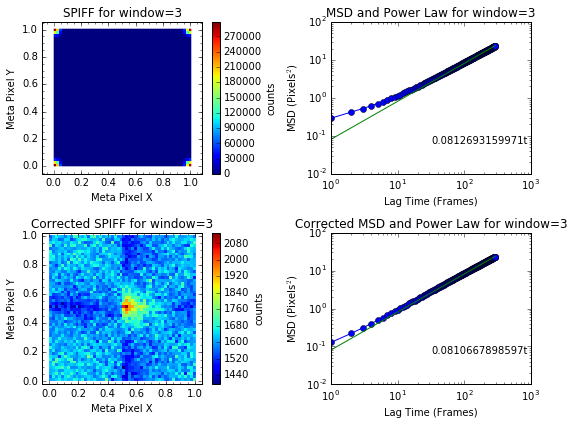

Average particles per frame = 4090.05435897


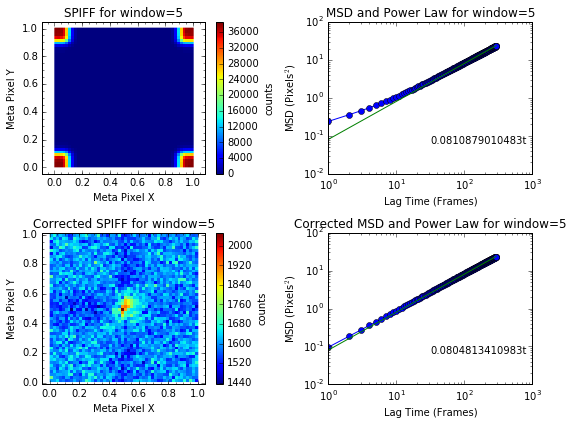

Average particles per frame = 4089.96205128


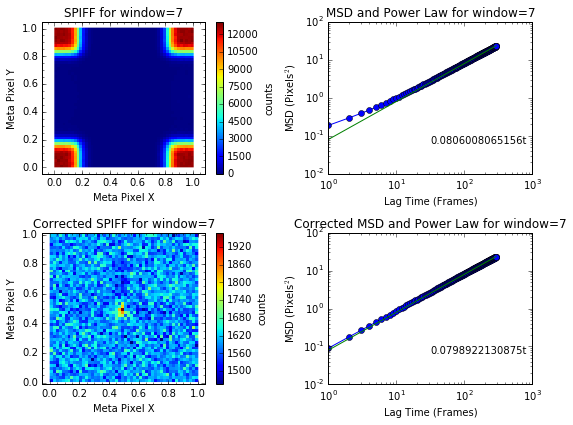

Average particles per frame = 4089.91487179


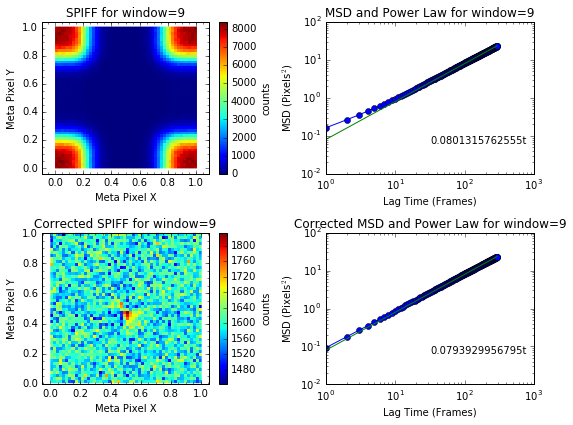

Average particles per frame = 4089.84820513


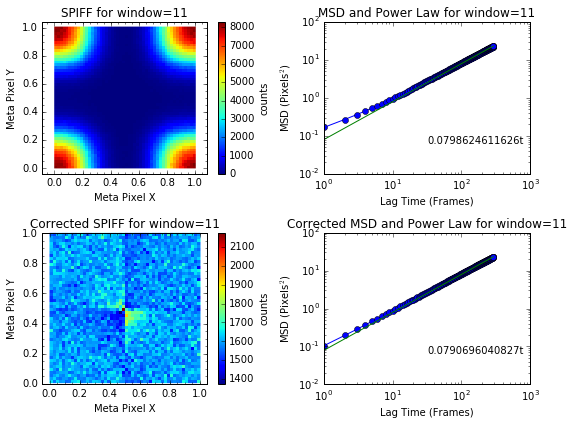

Average particles per frame = 4089.73948718


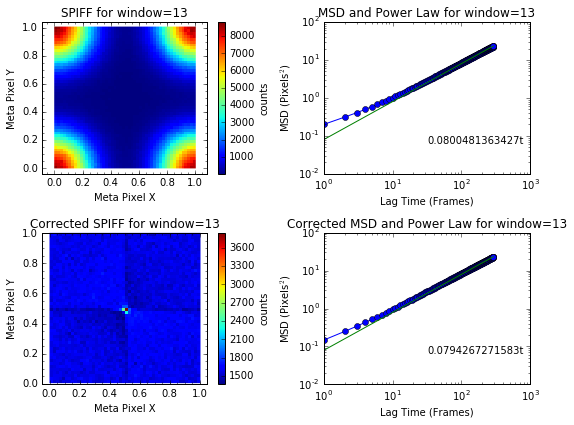

Average particles per frame = 4051.34461538


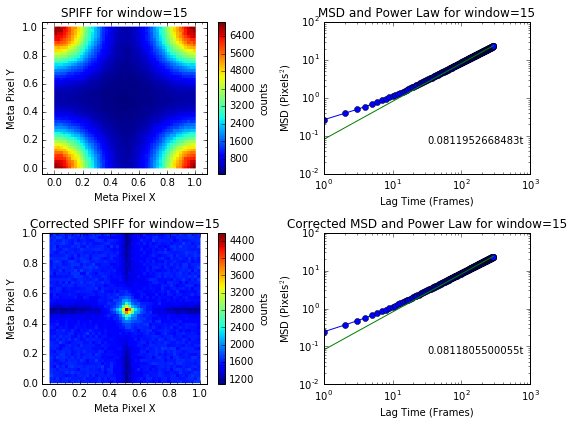

Average particles per frame = 4001.16205128


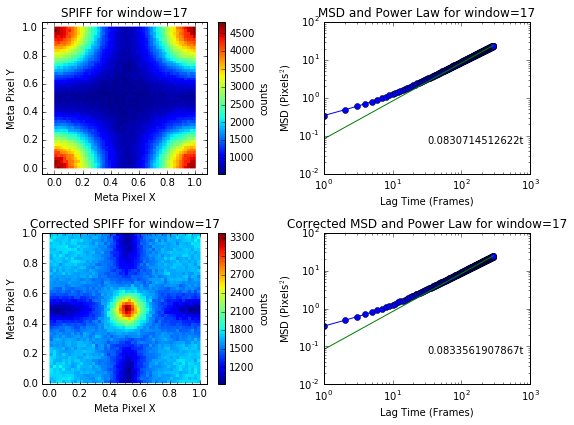

In [41]:
for num, entry in enumerate(corr_tracked_data):
    df, window = tracked_data[num]
    plt.figure(figsize=[8,6])
    plt.subplot(221)
    plt.hist2d(df['x pos']%1, df['y pos']%1, bins=50)
    plt.axis('equal')
    cbar = plt.colorbar()
    cbar.set_label('counts')
    plt.minorticks_on()
    plt.title('SPIFF for window='+str(window))
    plt.ylabel('Meta Pixel Y')
    plt.xlabel('Meta Pixel X')
    
    len_msd = len(en_msd[num][0])+1
    ax2 = plt.subplot(222)
    plt.plot(range(1,len_msd), en_msd[num][0], '-ob')
    pwr_law = lambda x, param: param*x
    fit_params = scipy.optimize.curve_fit(pwr_law, np.arange(1,len_msd)[-200:], en_msd[num][0][-200:])
    plt.plot(np.arange(1,len_msd), pwr_law(np.arange(1,len_msd), fit_params[0][0]), 'g')
    plt.loglog()
    ax2.text(0.5, 0.2, str(fit_params[0][0])+'t', transform=ax2.transAxes)
    plt.title('MSD and Power Law for window='+str(window))
    plt.ylabel('MSD (Pixels$^2$)')
    plt.xlabel('Lag Time (Frames)')
    plt.tight_layout()
    
    df, window = entry
    plt.subplot(223)
    plt.hist2d(df['x pos']%1, df['y pos']%1, bins=50)
    plt.axis('equal')
    cbar = plt.colorbar()
    cbar.set_label('counts')
    plt.minorticks_on()
    plt.title('Corrected SPIFF for window='+str(window))
    plt.ylabel('Meta Pixel Y')
    plt.xlabel('Meta Pixel X')
    
    len_msd = len(corr_en_msd[num][0])+1
    ax4 = plt.subplot(224)
    plt.plot(range(1,len_msd), corr_en_msd[num][0], '-ob')
    pwr_law = lambda x, param: param*x
    fit_params = scipy.optimize.curve_fit(pwr_law, np.arange(1,len_msd)[-200:], corr_en_msd[num][0][-200:])
    plt.plot(np.arange(1,len_msd), pwr_law(np.arange(1,len_msd), fit_params[0][0]), 'g')
    plt.loglog()
    ax4.text(0.5, 0.2, str(fit_params[0][0])+'t', transform=ax4.transAxes)
    plt.title('Corrected MSD and Power Law for window='+str(window))
    plt.ylabel('MSD (Pixels$^2$)')
    plt.xlabel('Lag Time (Frames)')
    plt.tight_layout()
    
    print 'Average particles per frame = '+str(df.groupby('frame').apply(len).mean())
    
    plt.show()